In [96]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [97]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [98]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [99]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [100]:
# def r2_loss(outputs, targets):
#     target_mean = torch.mean(targets)
#     ss_tot = torch.sum((targets - target_mean) ** 2)
#     ss_res = torch.sum((targets - outputs) ** 2)
#     r2 = 1 - ss_res / ss_tot
#     return r2

# def r2_loss_2(outputs, targets):
#     ss_tot = 0.0
#     ss_res = 0.0
#     target_mean = torch.mean(targets)
#     for i in range(0,len(outputs)):
#         ss_tot += (targets[i] - target_mean) ** 2
#         ss_res += (targets[i] - outputs[i]) ** 2
#     r2 = 1 - ss_res / ss_tot
#     return r2

def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = 1000.0 / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
      mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss

# print(torch.Tensor.float(1.0))
# outputs = torch.randn(5)
# targets = torch.randn(5)
outputs = torch.tensor([1,2,3,4,6])
targets = torch.tensor([[1],[2],[3],[4],[5]])
# print(outputs.size())
# print(r2_loss(outputs,targets))
# print(r2_loss_2(outputs,targets))
print(SPOLoss(outputs,targets))
print(SPO_MSE_Loss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor([2.9200])
tensor([2.9400])


In [101]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [102]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))
        # print('Train SPO MSE weighted Loss =', SPO_MSE_Loss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    # return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss Ave': SPO_mean})
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO_Loss': SPO, 'SPO_Loss_Per_Ord': SPO_mean, 'SPO_MSE_Weighted_Loss': SPO_MSE, 'SPO_MSE_Weighted_Loss_Per_Ord': SPO_MSE_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [103]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 501
        grid = np.linspace(0,0.5,11) if regularize == 'l2' else np.linspace(0,1,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(3,4,6) if regularize == 'l2' else np.linspace(10,20,5)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(list(aveloss.keys()), list(aveloss.values()))
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [104]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])

In [105]:
# cross_validate(x_train, y_train, 'MSE', 'l2')

In [106]:
# cross_validate(x_train, y_train, 'MSE', 'l1')

In [107]:
# cross_validate(x_train, y_train, 'SPO', 'l2')

In [108]:
# cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-0.48200113 -0.03602593 -0.14982899  0.4516804   1.3041515   0.2064091
  -0.9627364  -0.3975912   0.8301824   0.24376237  2.0250316   5.1498137
  -0.5553969   0.19514242  6.0199475   0.13699068  1.2226694  -1.3739332
  -1.8309617   5.426938    3.7738442   2.4182858   6.2438416  -6.4172654
  -0.5535238   2.7359884   0.03832189  0.7186899   0.36198848 -0.04093896
   0.40995622  2.218027    0.6986607  -0.4318758  -0.36704385]]
Train MSE = 58.00514883934444
Train R^2 = 0.7638928551451633
Train SPO Loss = [2050.73242682]


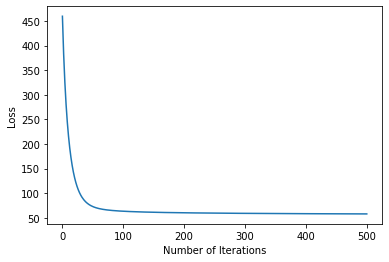

In [109]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

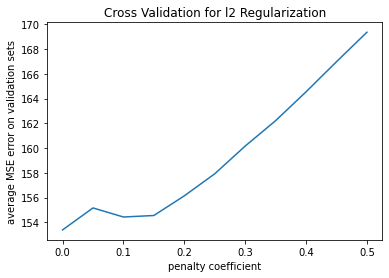

The best penalty coefficient is 0.0
Time:  8.545489303000068
model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-0.48593736 -0.04233969 -0.15040684  0.44982076  1.3125479   0.20529938
  -0.97199005 -0.38813752  0.8318765   0.25016636  2.0444474   5.174581
  -0.55154324  0.24108827  6.008621    0.13416822  1.2231572  -1.3930535
  -1.8428183   5.42307     3.7362325   2.4102786   6.2401533  -6.4336557
  -0.552119    2.7318783   0.03763985  0.71974677  0.35944277 -0.04039774
   0.4129151   2.2213151   0.7013357  -0.42823905 -0.36415008]]
Train MSE = 58.004854050476446
Train R^2 = 0.7638940550689519
Train SPO Loss = [2050.97066428]


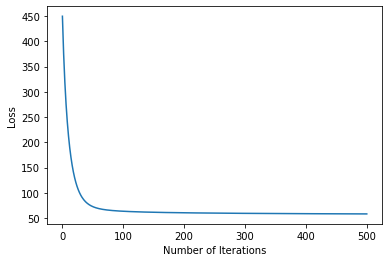

In [110]:
# ridge regression (l2 regrularization)

learningRate = 0.02
epochs = 501

# model training 

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

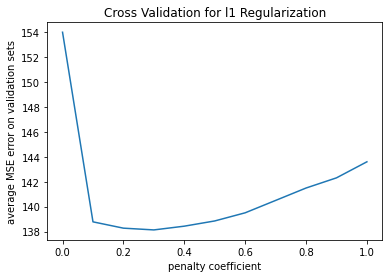

The best penalty coefficient is 0.30000000000000004
Time:  11.039767952999682
model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-1.2373058e-01  8.3271367e-03  6.1891752e-04  1.6826928e-03
   6.2748813e-03  1.8858992e-01 -5.6823012e-03 -3.9118657e-01
   1.0825877e+00 -2.2333886e-03  3.9547604e-01  3.8243361e+00
  -5.1279449e-01  3.4767580e-01  6.3908596e+00 -1.2558892e-01
   9.6104532e-01 -7.0826006e-03 -7.3533601e-01  5.6892076e+00
   3.1138320e+00  1.7674642e+00  6.3398089e+00 -5.0958753e+00
  -6.2310004e-01  1.9860915e+00 -1.0293068e-02  3.1349808e-01
   9.6474942e-03 -5.0561707e-03  1.9084629e-01  2.0222404e+00
   4.3413353e-01 -2.7703914e-01 -2.2820163e-01]]
Train MSE = 60.53739079900787
Train R^2 = 0.7535854870728274
Train SPO Loss = [2050.17697605]


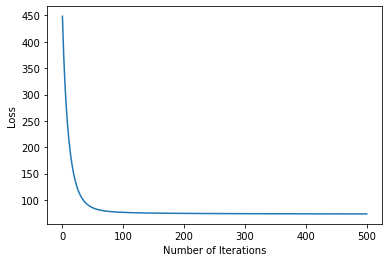

In [111]:
# l1 regularization (lasso) - penalty coefficient set to be 0.1

learningRate = 0.02
epochs = 501

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [112]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.005149  0.763893  2050.732427         10.357234   
          test   65.366637  0.596241   642.229658         11.267187   
mse_ridge train  58.004854  0.763894  2050.970664         10.358438   
          test   65.462804  0.595647   642.902962         11.278999   
mse_lasso train  60.537391  0.753585  2050.176976         10.354429   
          test   59.559264  0.632113   590.369879         10.357366   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
mse_ols   train            2056.532942                      10.386530  
          test              648.766322                      11.381865  
mse_ridge train            2056.771150                      10.387733  
          test              649.449243                      11.393846  
mse_lasso train            2056.230715                      10.385004  
          test              596.325805                      10.461856

## SPO loss models

### SPO loss model training

model trained using SPO loss
y-intercept  8.5609130859375
Coefficients  [[ 2.0527941e-01  3.2286662e-01  4.4387299e-01  1.5487896e-01
   1.0826606e-01  1.3999971e-02  1.3017203e-01  9.3286864e-02
  -5.2162729e-02  3.3258516e-01  1.6134037e+00  2.0237465e+00
   1.5076068e-01  3.1052272e+00  1.8470875e+00 -3.9459595e-01
   2.3481698e+00 -1.0871254e+00 -1.2653500e+00  4.3653460e+00
   3.8470164e-01  1.1002526e+00  1.7811775e+00 -2.4939814e+00
  -2.8155032e-01  9.0267473e-01  2.7528730e-01  4.4073558e-01
  -3.0243021e-02 -3.4326781e-02 -7.9284282e-04  3.0976528e-01
  -2.8030502e-02 -6.3551682e-01 -1.2216982e+00]]
Train MSE = 149.53816822453618
Train R^2 = 0.3913121394773662
Train SPO Loss = [1089.5740378]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


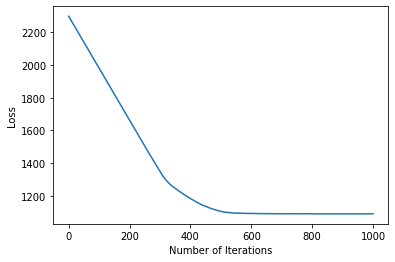

In [113]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

model trained using SPO loss
y-intercept  8.41914176940918
Coefficients  [[-1.1600575e-02 -1.3110809e-01  1.5645210e-01  1.7794533e-01
  -8.9672238e-02  3.0359030e-03  2.1895534e-01 -1.4992513e-02
   1.3569963e-01  2.0090226e-02  1.1362139e+00  1.1870487e+00
   9.5928811e-02  2.1492805e+00  1.9204068e+00 -5.4628265e-01
   1.9863530e+00 -7.5275040e-01 -1.1445509e+00  4.1691866e+00
   9.1501981e-01  1.0354015e+00  1.7689064e+00 -1.9366986e+00
  -5.0390345e-01  7.8046280e-01  2.7628574e-01  2.6716030e-01
   1.3721515e-01  1.8553138e-01  1.2902877e-01  3.2591078e-01
   1.8162230e-01 -5.4121840e-01 -8.5344046e-01]]
Train MSE = 155.9777407030747
Train R^2 = 0.3651001720500503
Train SPO Loss = [1109.50534681]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


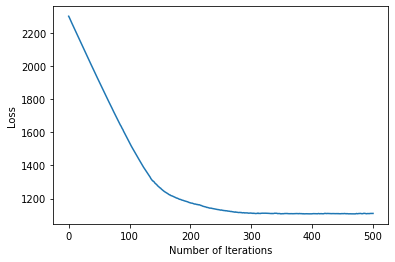

In [114]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo)

model trained using SPO loss
y-intercept  8.135887145996094
Coefficients  [[-5.0911596e-03  3.8891705e-03  3.7299099e-03  1.4206915e-01
   1.7911725e-03  7.4915523e-03  1.4552347e-01 -3.1044423e-03
   4.5133093e-01 -2.1394822e-03  1.3136776e-01  2.2018317e-04
  -5.1675704e-03  2.8285332e+00  2.1680624e+00 -3.5162124e-01
   1.4269166e+00 -1.1415407e-04 -4.6871147e-01  4.6337924e+00
   2.6970137e-02  9.3501015e-03  3.2348696e-03 -9.4952691e-01
  -3.6780688e-01  1.4210124e-02  1.3535999e-02  1.9634981e-03
  -2.2531645e-02  2.5017858e-03  2.2098173e-01  3.9568473e-02
   1.6238831e-01 -2.4258813e-01 -2.8263554e-01]]
Train MSE = 191.64223548562552
Train R^2 = 0.21992957591692475
Train SPO Loss = [1185.53949591]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


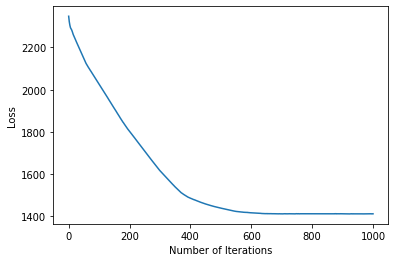

In [115]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 15)

### SPO MSE weighted loss model training

model trained using SPO_MSE loss
y-intercept  8.703691482543945
Coefficients  [[ 0.23540135  0.34567577  0.46675262  0.16733095  0.0876055   0.04075473
   0.13737866  0.0994238  -0.02029231  0.30640867  1.5774204   2.1995878
   0.14278725  3.0755007   1.9752686  -0.38410544  2.2411697  -1.058927
  -1.224068    4.3304014   0.3887457   1.0248201   3.514048   -2.7216198
  -0.27869633  0.87501     0.25624365  0.44599068 -0.02447628 -0.04680798
  -0.00996713  0.28914836 -0.04040591 -0.6400126  -1.2257804 ]]
Train MSE = 134.2353755776045
Train R^2 = 0.45360141469636006
Train SPO Loss = [1089.75786208]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


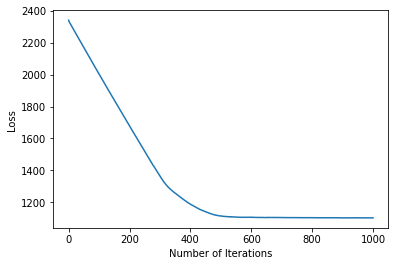

In [116]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','None')

model trained using SPO_MSE loss
y-intercept  8.462116241455078
Coefficients  [[-3.93373426e-03 -1.16239466e-01  1.51596755e-01  1.91757321e-01
  -9.95753706e-02  1.30125377e-02  2.46281028e-01  1.52456062e-03
   1.42401233e-01  5.02208062e-02  1.12661731e+00  1.21874738e+00
   7.74670616e-02  2.16857243e+00  1.91623151e+00 -5.31201065e-01
   2.01468205e+00 -7.40701258e-01 -1.13778961e+00  4.16842699e+00
   9.16644812e-01  1.03444195e+00  1.84327626e+00 -1.96278012e+00
  -5.04140735e-01  7.78821290e-01  2.97828257e-01  3.22899401e-01
   1.32230073e-01  2.04025224e-01  1.24788985e-01  3.68011832e-01
   1.79265067e-01 -5.33439636e-01 -8.60391259e-01]]
Train MSE = 154.47177257153746
Train R^2 = 0.3712301422836314
Train SPO Loss = [1106.88312907]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


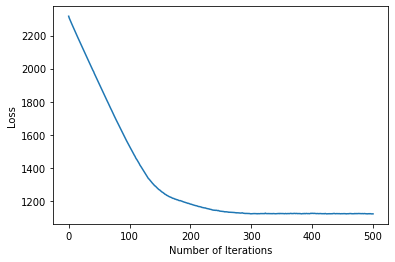

In [117]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','l2', l2_penalty = best_l2_spo)

model trained using SPO_MSE loss
y-intercept  8.142004013061523
Coefficients  [[-7.1799718e-03  4.4103046e-03  2.9893797e-03  1.5503389e-01
   2.0875211e-03  2.1467786e-03  1.3482095e-01  1.9819064e-03
   4.3850082e-01 -6.2216609e-04  1.3365373e-01  1.7288704e-03
   2.0593831e-03  2.8346932e+00  2.1829116e+00 -3.4198302e-01
   1.4205872e+00 -3.3244872e-03 -4.6599540e-01  4.6425867e+00
  -8.4123597e-04  3.7091561e-03  1.0269099e-02 -9.4938827e-01
  -3.5869366e-01 -1.6009901e-04  9.7692688e-04  2.2860831e-03
  -2.6169041e-02 -2.2149328e-03  2.1582310e-01  4.5851436e-02
   1.6413109e-01 -2.3192576e-01 -2.8609309e-01]]
Train MSE = 191.49943581980537
Train R^2 = 0.22051083503025637
Train SPO Loss = [1186.44336334]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


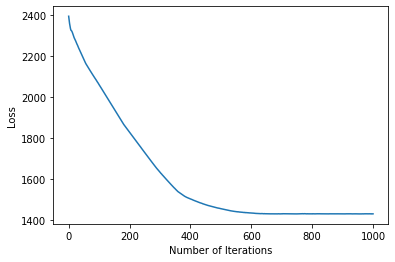

In [118]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE', 'l1', l1_penalty = 15)

### SPO loss model evaluation

In [119]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_ols   train  149.538168  0.391312  1089.574038          5.502899   
          test    98.588306  0.391037   404.771701          7.101258   
spo_ridge train  155.977741  0.365100  1109.505347          5.603562   
          test    99.867379  0.383136   385.457353          6.762410   
spo_lasso train  191.642235  0.219930  1185.539496          5.987573   
          test    98.960009  0.388741   352.525647          6.184660   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
spo_ols   train            1104.527855                       5.578424  
          test              414.630532                       7.274220  
spo_ridge train            1125.103121                       5.682339  
          test              395.444091                       6.937616  
spo_lasso train            1204.703719                       6.084362  
          test              362.421648                       6.358275

In [120]:
# SPO MSE weighted loss
SPO_result = []

for model, name in zip([model_ols_spo_mse, model_ridge_spo_mse, model_lasso_spo_mse],['spo_mse_ols','spo_mse_ridge','spo_mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_mse_ols   train  134.235376  0.453601  1089.757862          5.503828   
              test    96.843582  0.401814   405.304364          7.110603   
spo_mse_ridge train  154.471773  0.371230  1106.883129          5.590319   
              test    99.566655  0.384994   386.718411          6.784534   
spo_mse_lasso train  191.499436  0.220511  1186.443363          5.992138   
              test    98.794211  0.389765   351.451889          6.165823   

                     SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
spo_mse_ols   train            1103.181400                       5.571623  
              test              414.988723                       7.280504  
spo_mse_ridge train            1122.330306                       5.668335  
              test              396.675077                       6.959212  
spo_mse_lasso train            1205.593307                       6.088855  
              test              361.331310                       6.339146

In [123]:
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.005149  0.763893  2050.732427         10.357234   
          test   65.366637  0.596241   642.229658         11.267187   
mse_ridge train  58.004854  0.763894  2050.970664         10.358438   
          test   65.462804  0.595647   642.902962         11.278999   
mse_lasso train  60.537391  0.753585  2050.176976         10.354429   
          test   59.559264  0.632113   590.369879         10.357366   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
mse_ols   train            2056.532942                      10.386530  
          test              648.766322                      11.381865  
mse_ridge train            2056.771150                      10.387733  
          test              649.449243                      11.393846  
mse_lasso train            2056.230715                      10.385004  
          test              596.325805                      10.461856

# References

In [122]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
